# b-tagging Machine Learning 
## Sample preparation

The starting point for the training are xAODs. 
I use the datasets requested in ATLHI-240. 
In future shuld be replaced by dedicated derivations derivations. 
With the usage of [re-tagging](https://gitlab.cern.ch/atlas-flavor-tagging-tools/FlavourTagPerformanceFramework) framowork ntupels are produced from xAODs. 
To make it works on HI xAODs I needed to switch off few options in the job option. Working version is in my local clone of the package: 
* /afs/cern.ch/work/d/derendar/re_tagging/FlavourTagPerformanceFramework/run/jobOptions_noIncludes.py

Ntuples are thrn converted to the HDF5 files. 
This is done by a dedicated DL1 script, that convert ROOT files with uproot and can be found [here] (https://gitlab.cern.ch/atlas-flavor-tagging-tools/DL1_framework/blob/master/tools/convert_fromROOT.py)
(Alos in my local eos, directory /Users/derendar/cernbox/HI/2019.06.10_btag_baby_steps/trying_to_make_h5_file). 
Nice option of the script, it takes arguments --odd & --event -> conviniet for preparation of trainint and testing samples. 

For reference, ([uproot](https://uproot.readthedocs.io/en/latest/) is a nice tool to read ROOT files and transform them into numpy/pandas arrays)


In [1]:
# importing necessary packages
import h5py
import numpy as np
from numpy.lib.recfunctions import repack_fields
import pandas as pd
import json
from keras.utils import np_utils
import matplotlib.pyplot as plt
#print(pd.__version__)
pd.show_versions()

Using TensorFlow backend.



INSTALLED VERSIONS
------------------
commit           : 7d32926db8f7541c356066dcadabf854487738de
python           : 3.8.6.final.0
python-bits      : 64
OS               : Linux
OS-release       : 3.10.0-1160.6.1.el7.x86_64
Version          : #1 SMP Tue Nov 17 13:59:11 UTC 2020
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.2.2
numpy            : 1.18.2
pytz             : 2019.1
dateutil         : 2.8.0
pip              : 19.1.1
setuptools       : 44.1.0
Cython           : 0.29.20
pytest           : 6.1.1
hypothesis       : 5.3.0
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.6.2
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10.1
IPython          : 7.5.0
pandas_datareader: None
bs4              : None
bottleneck       : None


In [2]:
### traing files path
#file_path =  "/eos/user/s/shelena/btagging/sample_preparation/dijets_overaly_2015_JZ1_5_defaultGeV_alljet_50_500GeV_even"
#file_path =  "/eos/user/s/shelena/btagging/sample_preparation/JZ1_4_even_merge"
#file_path =  "/eos/user/s/shelena/btagging/sample_preparation"
file_path =  "/eos/user/v/vcondeme/HI_btagging_LIP/b_tagging_lip"

### test files path 
#test_file_path = "/eos/user/s/shelena/btagging/sample_preparation/dijets_overaly_2015_JZ1_5_defaultGeV_alljet_50_500GeV_odd"
#test_file_path = "/eos/user/s/shelena/btagging/sample_preparation/JZ1_4_odd_merge"
#test_file_path = "/eos/user/s/shelena/btagging/sample_preparation"

![alt text](img/downsampling.png)
First we define the downsampling of the samples. The principle is shown in the image above. In each pT and |eta| bin the same amount of jets are inserted for each flavour category (light, c- and b-jets). This is an alternative approach to re-weighting the pT and |eta| distributions in order to keep the training weights to 1.

In [3]:
from numpy.lib.recfunctions import repack_fields
def DownSampling(bjets, cjets, ujets):
    # pT in MeV
    pt_bins = np.linspace(0, 800000, 100)
    #pt_bins = np.linspace(0, 200000, 10)
    eta_bins = np.linspace(-2.5, 2.5, 10)
    
    

    histvals_b, _, _ = np.histogram2d(bjets['jet_eta'], bjets['jet_pt'],
                                [eta_bins, pt_bins])
    histvals_c, _, _ = np.histogram2d(cjets['jet_eta'], cjets['jet_pt'],
                                [eta_bins, pt_bins])
    histvals_u, _, _ = np.histogram2d(ujets['jet_eta'], ujets['jet_pt'],
                                [eta_bins, pt_bins])

    b_locations_pt = np.digitize(bjets['jet_pt'], pt_bins) - 1
    b_locations_eta = np.digitize(bjets['jet_eta'], eta_bins) - 1
    b_locations = zip(b_locations_pt, b_locations_eta)
    b_locations = list(b_locations)

    c_locations_pt = np.digitize(cjets['jet_pt'], pt_bins) - 1
    c_locations_eta = np.digitize(cjets['jet_eta'], eta_bins) - 1
    c_locations = zip(c_locations_pt, c_locations_eta)
    c_locations = list(c_locations)

    u_locations_pt = np.digitize(ujets['jet_pt'], pt_bins) - 1
    u_locations_eta = np.digitize(ujets['jet_eta'], eta_bins) - 1
    u_locations = zip(u_locations_pt, u_locations_eta)
    u_locations = list(u_locations)

    c_loc_indices = { (pti, etai) : [] for pti,_ in enumerate(pt_bins[::-1]) for etai,_ in enumerate(eta_bins[::-1])}
    b_loc_indices = { (pti, etai) : [] for pti,_ in enumerate(pt_bins[::-1]) for etai,_ in enumerate(eta_bins[::-1])}
    u_loc_indices = { (pti, etai) : [] for pti,_ in enumerate(pt_bins[::-1]) for etai,_ in enumerate(eta_bins[::-1])}
    print('Grouping the bins')
    for i, x in enumerate(c_locations):
        #print ('i: ', i , 'x: ', x )
        c_loc_indices[x].append(i)

    for i, x in enumerate(b_locations):
        b_loc_indices[x].append(i)

    for i, x in enumerate(u_locations):
        u_loc_indices[x].append(i)

    cjet_indices = []
    bjet_indices = []
    ujet_indices = []
    print('Matching the bins for all flavours')
    for pt_bin_i in range(len(pt_bins) - 1):
        for eta_bin_i in range(len(eta_bins) - 1):
            loc = (pt_bin_i, eta_bin_i)

            nbjets = int(histvals_b[eta_bin_i][pt_bin_i])
            ncjets = int(histvals_c[eta_bin_i][pt_bin_i])
            nujets = int(histvals_u[eta_bin_i][pt_bin_i])

            njets = min([nbjets, ncjets, nujets])
            c_indices_for_bin = c_loc_indices[loc][0:njets]
            b_indices_for_bin = b_loc_indices[loc][0:njets]
            u_indices_for_bin = u_loc_indices[loc][0:njets]
            cjet_indices += c_indices_for_bin
            bjet_indices += b_indices_for_bin
            ujet_indices += u_indices_for_bin

    cjet_indices.sort()
    bjet_indices.sort()
    ujet_indices.sort()
    return np.array(bjet_indices), np.array(cjet_indices), np.array(ujet_indices)

Due to the different $p_T$ distributions of the b-, c-, and light flavour jets, we need a factor 2-3 more c- and light flavour jets as input for the downsampling.

In [4]:
Njets = 100000000 
nZ = int(Njets*3*(1/0.65-1))
ncjets = int(2.3 * Njets)
nujets = int(2.7 * Njets)

Please change the diretory to your path where you have the files stored

In [5]:
Zprime_file = file_path + "/JZ1_5_even.h5"
#JZ1_4_HS_odd_merge_half.h5
#Zprime_file = file_path + "/zp_nom-000188_sub0.h5"
df_Zprime = h5py.File(Zprime_file, "r")['jets'][:] ### all 

In [6]:
binning = {"jet_pt": np.linspace(10000, 800000, 100),#/1000,
               "jet_eta": np.linspace(0, 2.5, 26)}
var = "jet_pt"

plt.hist(df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==5][var]/1000, binning[var]/1000, histtype='step',
         label=["b-jets"], 
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)

plt.xlabel('$p_T$ [GeV]',fontsize=12)
plt.ylabel('# jets',fontsize=12)
plt.yscale('log')
#plt.legend()

In [7]:
print(len(df_Zprime[1]))

79


In [8]:
bjets = df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==5]
cjets = df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==4]
ujets = df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==0]


print(bjets.shape)
print('b: ', bjets.size)
print('c: ', cjets.size)
print('u: ', ujets.size)
print('total size: ', bjets.size + cjets.size + ujets.size)
bjet_indices, cjet_indices, ujet_indices = DownSampling(bjets, cjets, ujets)

(245400,)
b:  245400
c:  510259
u:  7613000
total size:  8368659
Grouping the bins
Matching the bins for all flavours


In [9]:
bjets = bjets[bjet_indices]
cjets = cjets[cjet_indices]
ujets = ujets[ujet_indices]

In [10]:
print('b: ', bjets.size)
print('c: ', cjets.size)
print('u: ', ujets.size)
print('total size: ', bjets.size + cjets.size + ujets.size)
print(len(bjets[0]))

b:  245394
c:  245394
u:  245394
total size:  736182
79


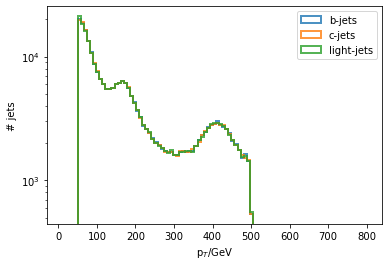

In [11]:
plt.hist(bjets[var]/1000, binning[var]/1000, histtype='step',
         label=["b-jets"],
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(cjets[var]/1000, binning[var]/1000, histtype='step',
         label=["c-jets"], 
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(ujets[var]/1000, binning[var]/1000, histtype='step',
         label=["light-jets"],
         stacked=False, 
         fill=False,
         linewidth=2, alpha=0.8)
plt.xlabel('p$_T$/GeV')
plt.ylabel('# jets')
plt.yscale('log')
plt.legend()

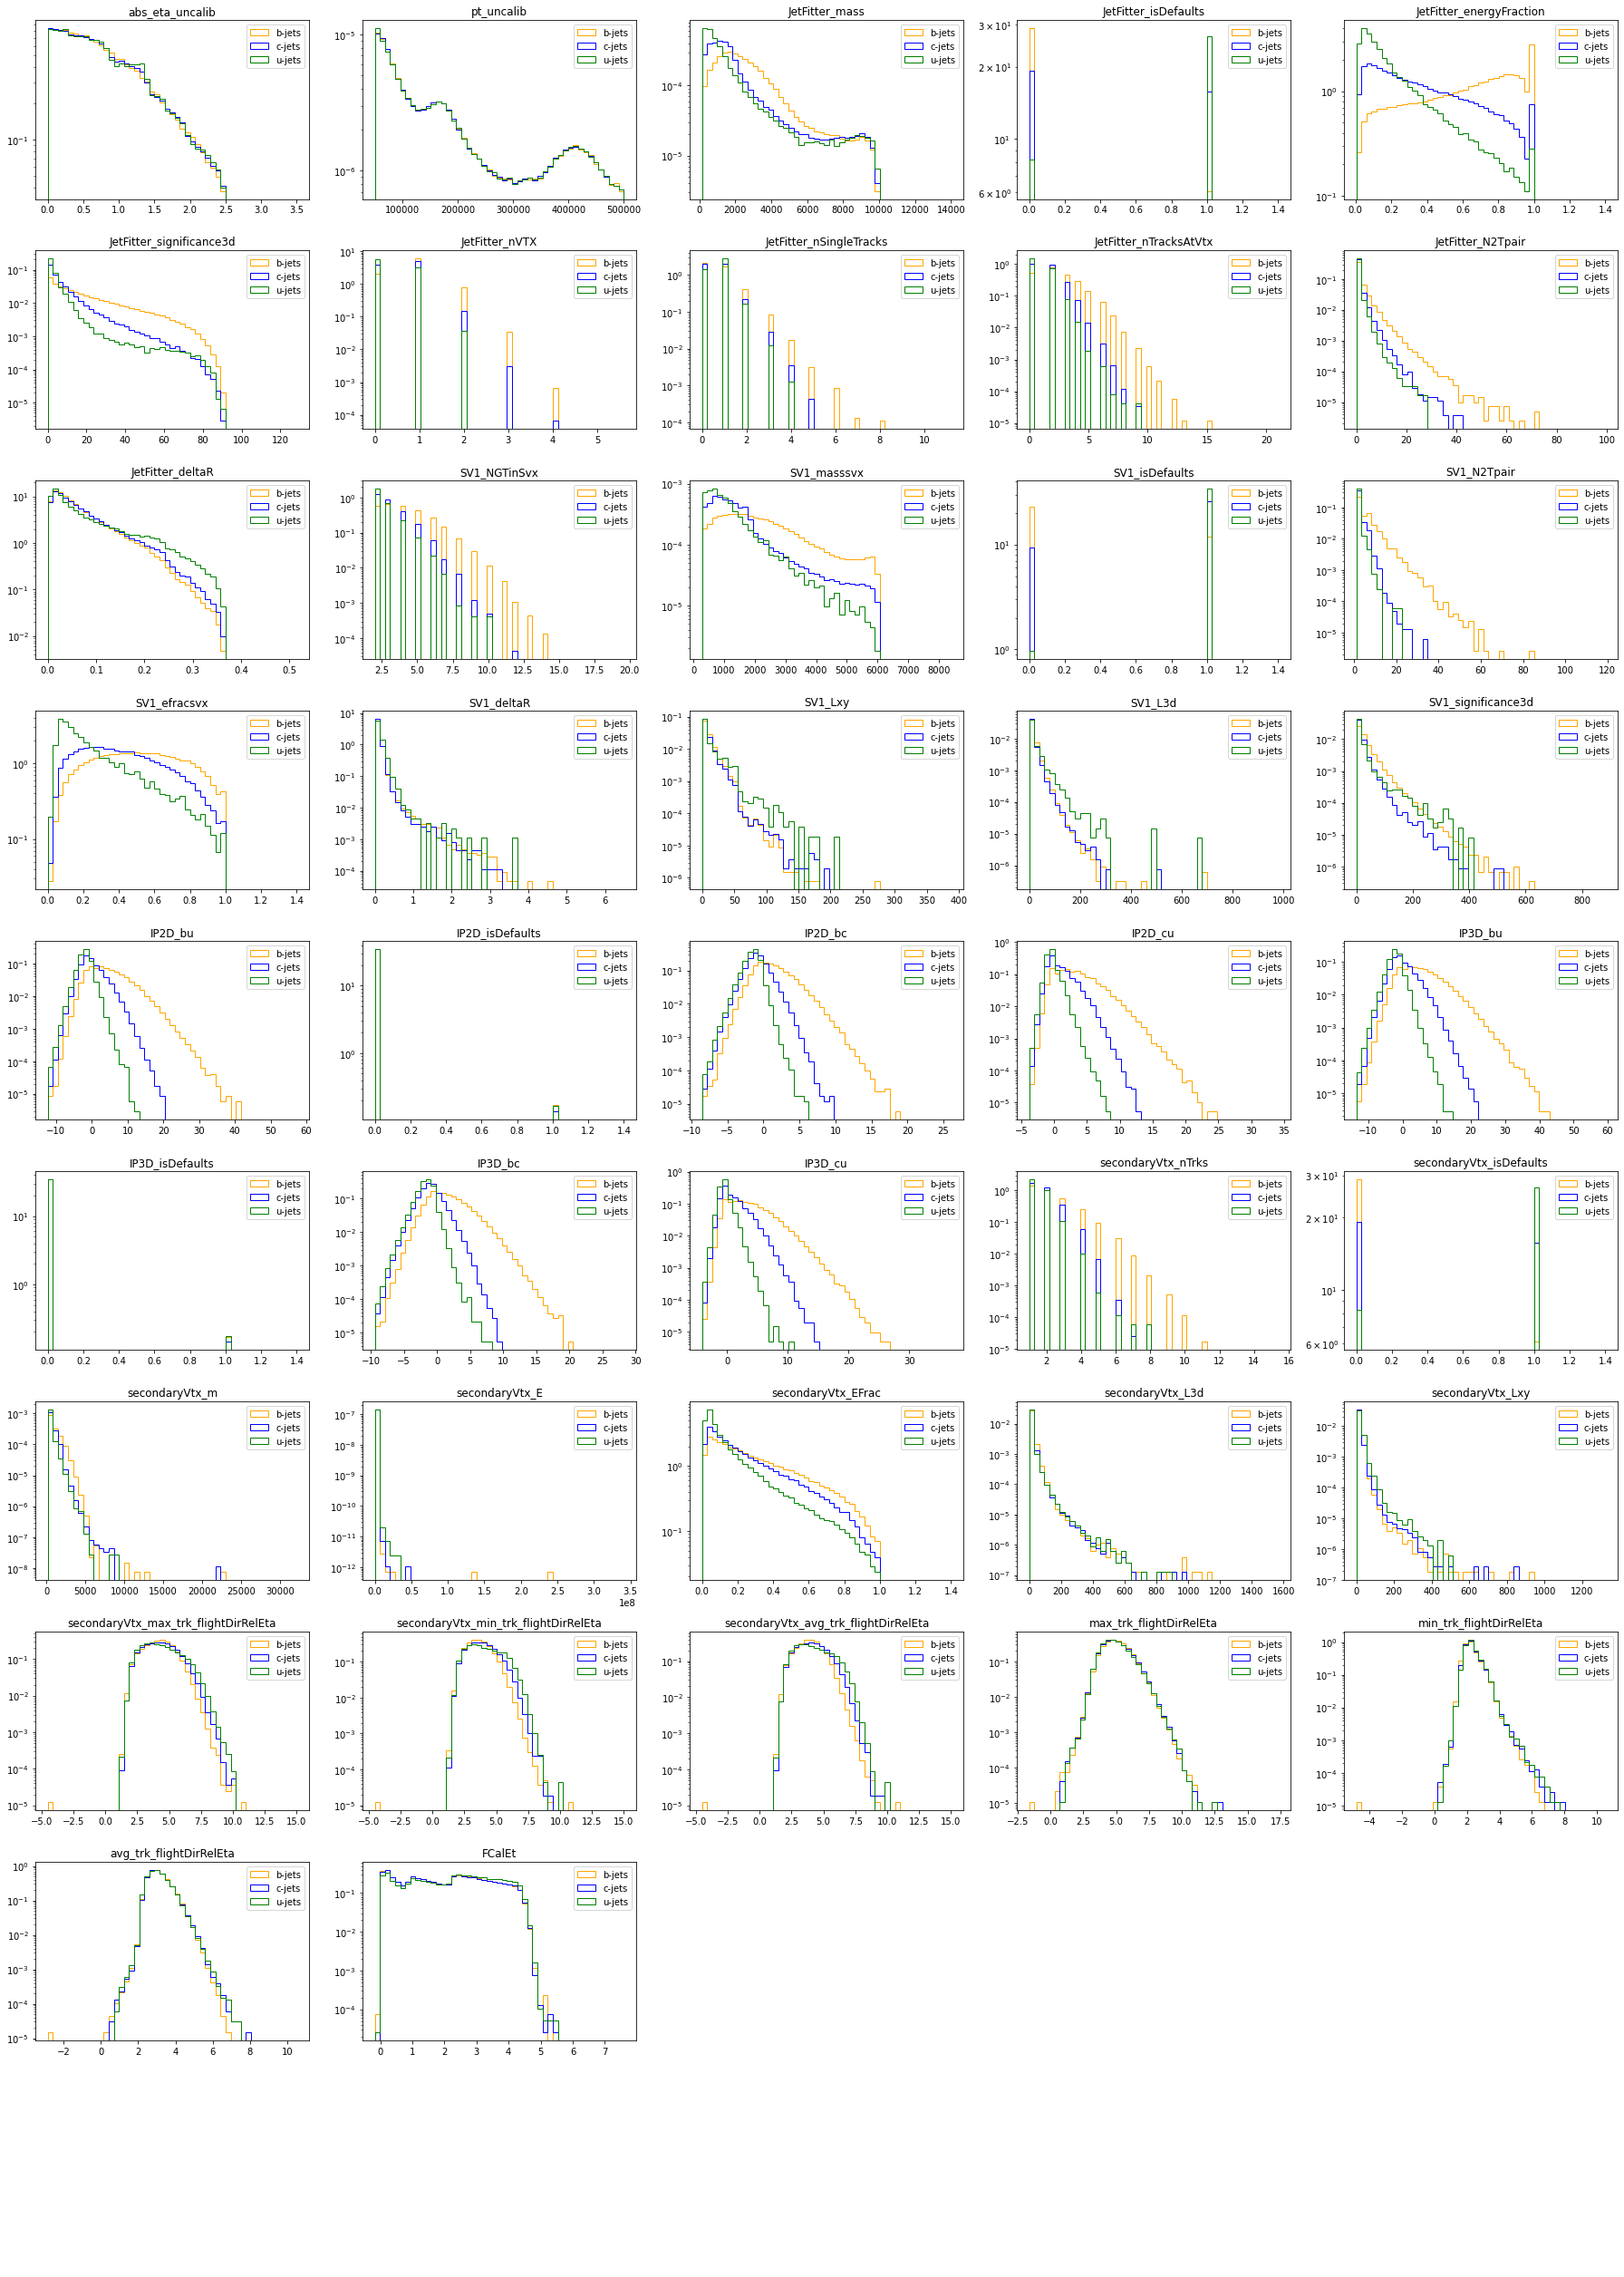

In [12]:
fig, ax = plt.subplots(10, 5, figsize=(25, 35))
nbins = 50

with open("HI_DL1r_Variables.json") as vardict:
    variablelist = json.load(vardict)[:]
variablelist.remove("HadronConeExclTruthLabelID")
varcounter = -1
for i, axobjlist in enumerate(ax):
      for j, axobj in enumerate(axobjlist):
        varcounter+=1
        if varcounter < len(variablelist):
            var = variablelist[varcounter]
        
            b = pd.DataFrame({var: bjets[var]})
            c = pd.DataFrame({var: cjets[var]})
            u = pd.DataFrame({var: ujets[var]})
            b.replace([np.inf, -np.inf], np.nan, inplace=True)
            c.replace([np.inf, -np.inf], np.nan, inplace=True)
            u.replace([np.inf, -np.inf], np.nan, inplace=True)
    
            b = b.dropna()
            c = c.dropna()
            u = u.dropna()

            
            minval = np.amin(b[var])
            if 'pt' in var:
                maxval = np.percentile(u[var],99.99)
            else:
                maxval = max([np.amax(u[var]), np.amax(b[var])])*1.4
            binning = np.linspace(minval,maxval,nbins)


            axobj.hist(b[var],binning,histtype=u'step', color='orange',label='b-jets',density=1)
            axobj.hist(c[var],binning,histtype=u'step', color='b',label='c-jets',density=1)
            axobj.hist(u[var],binning,histtype=u'step', color='g',label='u-jets',density=1)

            
            axobj.legend()
            axobj.set_yscale('log',nonpositive='clip')
            axobj.set_title(variablelist[varcounter])

        else:
            axobj.axis('off')

plt.tight_layout()
plt.savefig("DL1r-variables_1GeV.pdf", transparent=True)
plt.show()

In [3]:
def Gen_default_dict(scale_dict):
    """Generates default value dictionary from scale/shift dictionary."""
    default_dict = {}
    for elem in scale_dict:
        if 'isDefaults' in elem['name']:
            continue
        default_dict[elem['name']] = elem['default']
    return default_dict

In [4]:
with open("HI_DL1r_Variables.json") as vardict:
    var_names = json.load(vardict)[:]
def ScaleVariables(bjets, cjets, ujets):
    with open("params_MC16D-ext_2018-PFlow_70-8M_mu.json", 'r') as infile:
        scale_dict = json.load(infile)
    bjets = pd.DataFrame(bjets)
    cjets = pd.DataFrame(cjets)
    ujets = pd.DataFrame(ujets)
    bjets.replace([np.inf, -np.inf], np.nan, inplace=True)
    cjets.replace([np.inf, -np.inf], np.nan, inplace=True)
    ujets.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Replace NaN values with default values from default dictionary
    default_dict = Gen_default_dict(scale_dict)
    bjets.fillna(default_dict, inplace=True)
    cjets.fillna(default_dict, inplace=True)
    ujets.fillna(default_dict, inplace=True)
    # scale and shift distribution
    for elem in scale_dict:
        if 'isDefaults' in elem['name']:
            continue
        if elem['name'] not in var_names:
            continue
        else:
            bjets[elem['name']] = ((bjets[elem['name']] - elem['shift']) /
                                  elem['scale'])
            cjets[elem['name']] = ((cjets[elem['name']] - elem['shift']) /
                                  elem['scale'])
            ujets[elem['name']] = ((ujets[elem['name']] - elem['shift']) /
                                  elem['scale'])
    return bjets.to_records(index=False, column_dtypes='float64'), cjets.to_records(index=False, column_dtypes='float64'), ujets.to_records(index=False, column_dtypes='float64')


In [15]:
bjets_scaled, cjets_scaled, ujets_scaled = ScaleVariables(bjets, cjets, ujets)

Also, scale the track variables. Here we just have to be careful not to include the masked values in the calculation of the mean and variance.




We don't need all the variables that the training dataset dumper prints out. Variables that are natually close to or centered around 0 we don't scale.

Furthermore, for some of the variables that follow a power law spectrum ($p_T^{frac}$ and $\Delta R$), we take the log of to make them more Gaussian like before transforming.

In [16]:
if 'HadronConeExclTruthLabelID' in var_names:
    var_names.remove('HadronConeExclTruthLabelID')
print('concatenating flavour samples')

X_train = np.concatenate((ujets_scaled, cjets_scaled, bjets_scaled))
y_train = np.concatenate((np.zeros(len(ujets_scaled)),
                          np.ones(len(cjets_scaled)),
                          2 * np.ones(len(bjets_scaled))))

Y_train = np_utils.to_categorical(y_train, 3)
X_train = repack_fields(X_train[var_names])
print(len(X_train[0]))
X_train = X_train.view(np.float64).reshape(X_train.shape + (-1,))

rng_state = np.random.get_state()
# shuffle the arrays
print('shuffle arrays')
np.random.shuffle(X_train)
np.random.set_state(rng_state)
np.random.shuffle(Y_train)
print ('X_train',type(X_train), 'len(): ', len(X_train))
print ('Y_train',type(Y_train), 'len(): ', len(Y_train))
assert X_train.shape[1] == len(var_names)

concatenating flavour samples
42
shuffle arrays
X_train <class 'numpy.ndarray'> len():  736182
Y_train <class 'numpy.ndarray'> len():  736182


In [17]:
print(X_train.shape)
print(len(var_names))

(736182, 42)
42


In [18]:
outfile_name = "three_datasets/training_1.h5" ## training set para os dois metodos originais
h5f = h5py.File(outfile_name, 'w')
h5f.create_dataset('X_train', data=X_train, compression='gzip')
h5f.create_dataset('Y_train', data=Y_train, compression='gzip')
h5f.close()

In [19]:
train_size = X_train.shape
print(train_size)
del X_train

(736182, 42)


In [20]:
print(Y_train.size)
print(X_train.shape)

2208546


NameError: name 'X_train' is not defined

In [21]:
print(Y_train.shape)

(736182, 3)


The same procedure is then repeated for the validation/training sample

In [7]:
if 'HadronConeExclTruthLabelID' in var_names:
    var_names.remove('HadronConeExclTruthLabelID')
    
def GetTestSample(jets):
    with open("params_MC16D-ext_2018-PFlow_70-8M_mu.json", 'r') as infile:
        scale_dict = json.load(infile)
        
    jets = pd.DataFrame(jets)
    
    print("check key", "HadronConeExclTruthLabelID" in jets.columns.values)
    jets.query('(HadronConeExclTruthLabelID<=5)', inplace=True)
    jets_pt_eta = jets.loc[:, ('jet_pt', 'jet_eta')]
    #print ('jets_pt_eta', jets_pt_eta)
    labels = jets.loc[:, 'HadronConeExclTruthLabelID'].values
    #jets = jets[var_names]
    print(len(var_names))
    jets = jets.loc[:, var_names]
    #print ('jets', jets)
    jets.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Replace NaN values with default values from default dictionary
    default_dict = Gen_default_dict(scale_dict)
    jets.fillna(default_dict, inplace=True)
    # scale and shift distribution
    for elem in scale_dict:
        if 'isDefaults' in elem['name']:
            continue
        if elem['name'] not in var_names:
            continue
        else:
            jets[elem['name']] = ((jets[elem['name']] - elem['shift']) / elem['scale']) #causes caveats
            #jets.loc[elem['name']] = ((jets[elem['name']] - elem['shift']) / elem['scale']) # causes (in DL1_Training) ValueError: Data cardinality is ambiguous: x sizes: 2203905, 2203869
    
    labels_cat = np.copy(labels)
    labels_cat[labels_cat==5] = 2
    labels_cat[labels_cat==4] = 1
    labels_cat = np_utils.to_categorical(labels_cat, 3)
    print ('labels', labels)
    print ('len labels', len(labels))
    print ('type of labels', type(labels))
    print ('shape of labels', labels.shape)
    print ('example values', labels[110])
    return jets.values, jets_pt_eta.to_records(index=False), labels, labels_cat

In [5]:
test_file_path = "/eos/user/v/vcondeme/HI_btagging_LIP/b_tagging_lip"
test_file = test_file_path + "/JZ1_5_odd.h5"
#test_file_path = "/eos/user/s/shelena/SWAN_projects/Projecto_estagio"
#test_file = test_file_path + "/JZ1_4_HS_odd_merge.h5"

#test_file = test_file_path + "/JZ123_HS_odd_merge.h5"
df_test = h5py.File(test_file, "r")['jets'][:] ### all 


In [8]:
X_test, jpt, labels, Y_test = GetTestSample(df_test)

check key True
42
labels [0 0 0 ... 0 0 0]
len labels 8380435
type of labels <class 'numpy.ndarray'>
shape of labels (8380435,)
example values 0


In [9]:
rng_state = np.random.get_state()
# shuffle the arrays
print('shuffle arrays')
np.random.shuffle(X_test)
np.random.set_state(rng_state)
np.random.shuffle(Y_test)

shuffle arrays


In [10]:
print(X_test.size)
print(X_test.shape)
print(Y_test.size)
print(Y_test.shape)

351978270
(8380435, 42)
25141305
(8380435, 3)


In [11]:
#dividir ao meio
split = int(X_test.shape[0]/2)
print(split)
X_valid = X_test[:split, :]
Y_valid = Y_test[:split, :]
X_test = X_test[split:, :]
Y_test = Y_test[split:, :]

4190217


In [12]:
print(X_test.size)
print(X_test.shape)
print(Y_test.size)
print(Y_test.shape)

print(X_valid.size)
print(X_valid.shape)
print(Y_valid.size)
print(Y_valid.shape)

175989156
(4190218, 42)
12570654
(4190218, 3)
175989114
(4190217, 42)
12570651
(4190217, 3)


In [13]:
outfile_name = "three_datasets/testing_1_all.h5" ##metodo original 1, testing set grande
h5f = h5py.File(outfile_name, 'w')
h5f.create_dataset('X_test', data=X_test, compression='gzip')
h5f.create_dataset('Y_test', data=Y_test, compression='gzip')
h5f.close()

In [14]:
outfile_name = "three_datasets/validation_1_all.h5" ##metodo original 1, testing set grande
h5f = h5py.File(outfile_name, 'w')
h5f.create_dataset('X_valid', data=X_valid, compression='gzip')
h5f.create_dataset('Y_valid', data=Y_valid, compression='gzip')
h5f.close()

In [15]:
##metodo original 2, filtar para proporções normais, hardcoded
train_size = 736182
valid_size = int(15/70*train_size)
print(valid_size)
X_valid = X_valid[:valid_size]
Y_valid = Y_valid[:valid_size]
X_test = X_test[:valid_size]
Y_test = Y_test[:valid_size]

157753


In [16]:
outfile_name = "three_datasets/testing_1_proportional.h5" ##metodo original 1, testing set proporcional
h5f = h5py.File(outfile_name, 'w')
h5f.create_dataset('X_test', data=X_test, compression='gzip')
h5f.create_dataset('Y_test', data=Y_test, compression='gzip')
h5f.close()

In [17]:
outfile_name = "three_datasets/validation_1_proportional.h5" ##metodo original 1, testing set proporcional
h5f = h5py.File(outfile_name, 'w')
h5f.create_dataset('X_valid', data=X_valid, compression='gzip')
h5f.create_dataset('Y_valid', data=Y_valid, compression='gzip')
h5f.close()